In [ ]:
!pip install opencv-python
!pip install torch
!pip install ultralytics

In [ ]:
import pickle
import argparse
import os
import shutil
import time
import cv2

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import sys
import math
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split

##**Utils**

<ipython-input-12-e562257ffa36>:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout


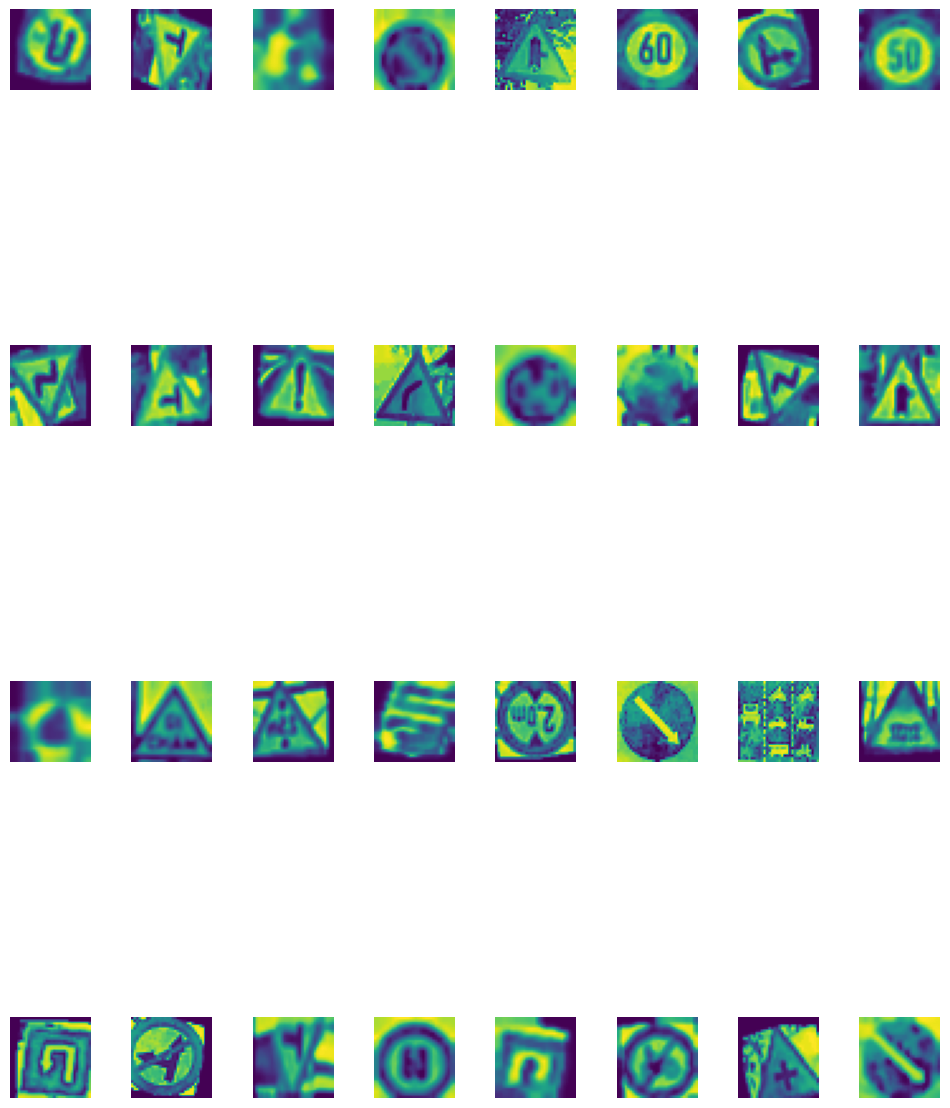

2919


In [ ]:
label_name_mapping = {
    0: "3-junction",
    1: "One-way road",
    2: "Side to obe followed",
    3: "Cross road",
    4: "Intersection with Uncontrolled Road",
    5: "Dangerous turn",
    6: "No Left turn",
    7: "Bus stop",
    8: "Roundabout",
    9: "No parking and stopping",
    10: "U-turn",
    11: "Lane-allocation",
    12: "No left turn for motorcycles",
    13: "Slow Down",
    14: "No Trucks Allowed",
    15: "Narrow Road on the Right",
    16: "No Passenger Cars and Trucks",
    17: "Height Limit",
    18: "No U-Turn",
    19: "No U-Turn and No Right Turn",
    20: "No Cars Allowed",
    21: "Narrow Road on the Left",
    22: "Uneven Road",
    23: "No Two or Three-wheeled Vehicles",
    24: "Customs Checkpoint",
    25: "Motorcycles Only",
    26: "Obstacle on the Road",
    27: "Children Presence",
    28: "Trucks and Containers",
    29: "No Motorcycles Allowed",
    30: "Trucks Only",
    31: "Road with Surveillance Camera",
    32: "No Right Turn",
    33: "Series of Dangerous Turns",
    34: "No Containers Allowed",
    35: "No Left or Right Turn",
    36: "No Straight and Right Turn",
    37: "Intersection with T-Junction",
    38: "Speed limit (50km/h)",
    39: "Speed limit (60km/h)",
    40: "Speed limit (80km/h)",
    41: "Speed limit (40km/h)",
    42: "Left Turn",
    43: "Low Clearance",
    44: "Other Danger",
    45: "Go Straight",
    46: "No Parking",
    47: "No Left or U-turn",
    48: "No U-Turn for Cars",
    49: "Level Crossing with Barriers"
}

def display_batch(images, labels_tensor, confidence_tensor):

    for i, (top_preds, top_lbls) in enumerate(zip(confidence_tensor, labels_tensor)):  # Iterate over each image in the batch
      fig = plt.figure(figsize=(10, 5))
      conf_list = top_preds.tolist()
      lbl_list  = top_lbls.tolist()

      # Create a grid layout with 1 row and 2 columns
      gs = plt.GridSpec(1, 2, width_ratios=[1, 1])  # Left 1: image, right 2: bar chart

       # Left: Show the image
      ax1 = fig.add_subplot(gs[0])
      ax1.imshow(images[i].permute(1, 2, 0))  # Show the image for the current batch item
      ax1.axis('off')  # Turn off the axis for the image

      # Right: Create the horizontal bar chart for the current image's top 5 predictions
      ax2 = fig.add_subplot(gs[1])

      # Convert label indices to strings (or use a custom mapping if you have label names)
      labels_str = [f"{label_name_mapping[lbl]}" for lbl in lbl_list]

      # Plot the horizontal bar chart
      bars = ax2.barh(labels_str, conf_list, color='skyblue')

      # Add confidence values at the end of each bar
      for bar, confidence in zip(bars, conf_list):
        ax2.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f'{confidence:.2f}', va='center')

      plt.xlabel('Confidence')
      plt.xlim(0, 1)  # Assuming confidence is in the range 0 to 1, adjust if necessary
      plt.tight_layout()
      plt.show()

def pickle_data(file, writeColumns=None):
    """
    Read/Write pickle training/testing data, models to avoid
    loading data again (time consuming)

    :param file: path to pickle file
    :param writeColumns (torch.Tensor or np.ndarray): variables to be saved to pickle file

    :returns :
    If writeColumns = None -> tuple(torch.Tensor)
    tuple()
    """
    if writeColumns is None:
        with open(file, mode="rb") as f:
            dataset = pickle.load(f)
            return tuple( # Convert the pickled data into tensor if it is of any other types
                map(lambda col: torch.tensor(dataset[col])
                    if not type(dataset[col]) == torch.Tensor else dataset[col],
                    ['images', 'labels'])
                )
                # lambda(col) where columns are the inputs
    else:
        with open(file, mode="wb") as f:
            dataset = pickle.dump({"images": writeColumns[0], "labels": writeColumns[1]}, f)
            print("Data is saved in", file)

    def preprocess_batch(batch_tensor):
      preprocessed_image = []
      idx = 0
      for img_tensor in batch_tensor:
         # Convert tensor to numpy array
        #print("{}: {}".format(idx, img_tensor.size()))
        img_np = img_tensor.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

         # Convert from [0, 1] or [0, 255] to [0, 255] and ensure uint8 type
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)

        img_res = preprocess(img_np)
        img_tensor = torch.from_numpy(img_res).unsqueeze(0)
        preprocessed_image.append(img_tensor)
        idx += 1

      preprocessed_tensor = torch.stack(preprocessed_image)
      return preprocessed_tensor

def preprocess(image):
    if image.shape[2] > 1:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # Noise reduction
      image = cv2.GaussianBlur(image, (3, 3), 1,5)
      # Histogram equalization
      image = cv2.equalizeHist(image)
      # Image eroding
      image = cv2.erode(image, (3, 3))
      # Resize image
      image = cv2.resize(image, (32, 32))
    return image

class CustomDataset(TensorDataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Vietnam
torch.manual_seed(41)
vietnam_imgs, vietnam_labels = pickle_data(file = '/content/drive/MyDrive/TrafficSignData/Vietnam/gray_processed_dataset') # Update your path
portion    = 0.8
train_size = int(portion * len(vietnam_imgs))
val_size   = len(vietnam_imgs) - train_size
train_dataset, val_dataset = random_split(list(zip(vietnam_imgs, vietnam_labels)), [train_size, val_size])

# Investigate the dataset
batch_size = 32
images_per_row = 8
num_rows = batch_size // images_per_row + (1 if batch_size % images_per_row > 0 else 0)
sample_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(12, 4 * num_rows), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})
axes = axes.flatten()
for _, (input, target) in enumerate(sample_loader):
  for img_idx in range(batch_size):
    axes[img_idx].imshow(input[img_idx].permute(1, 2, 0))  # Display the image
    axes[img_idx].axis('off')  # Turn off the axis
  break
plt.tight_layout()  # Adjust layout
plt.show()
print(len(val_dataset))

## **Network**


In [ ]:
#%%writefile my_mainScript.py

# Ensure that the input tensor size is [batch_size, channel, width, heigh]
# Ensure that the labels are int64
# Ensure that the ouput of the classfier matches the number of classes

supportedArch = [
    'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]

class VGG(nn.Module):
    '''
    VGG model
    '''
    def __init__(self, vgg_blocks):
        super(VGG, self).__init__()
        self.layers = nn.ModuleList(vgg_blocks)
        self.maxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1408, 1024), 
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 50),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
      output = []
      tmpInput = x
      # 1. VGG blocks
      for layerIdx, layer in enumerate(self.layers):
        current_output = layer(tmpInput)
        output.append(current_output)
        tmpInput = current_output

      # 2. Multiscale Convolutional Network
      output_m1 = torch.cat((self.maxPool (output[1]), output[2]), 1)
      output_m2 = torch.cat((self.maxPool (output_m1), output[3]), 1)
      output_m3 = torch.cat((self.maxPool (output_m2), output[4]), 1)

      ouput_pre_classification = output_m3.view(output_m3.size(0), -1)
      final_ouput = self.classifier(ouput_pre_classification)
      return final_ouput

    def vgg11():
        """VGG 11-layer model (configuration "A")"""
        return VGG(make_layers(cfg['A']))


    def vgg11_bn():
        """VGG 11-layer model (configuration "A") with batch normalization"""
        return VGG(make_layers(cfg['A'], batch_norm=True))


    def vgg13():
        """VGG 13-layer model (configuration "B")"""
        return VGG(make_layers(cfg['B']))


    def vgg13_bn():
        """VGG 13-layer model (configuration "B") with batch normalization"""
        return VGG(make_layers(cfg['B'], batch_norm=True))


    def vgg16():
        """VGG 16-layer model (configuration "D")"""
        return VGG(make_layers(cfg['D']))


    def vgg16_bn():
        """VGG 16-layer model (configuration "D") with batch normalization"""
        return VGG(make_layers(cfg['D'], batch_norm=True))


    def vgg19():
        """VGG 19-layer model (configuration "E")"""
        return VGG(make_layers(cfg['E']))


    def vgg19_bn():
        """VGG 19-layer model (configuration 'E') with batch normalization"""
        return VGG(make_layers(cfg['E'], batch_norm=True))

def make_layers(cfg, batch_norm=False):
    layers = []
    vgg_blocks = []
    in_channels = 1
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            vgg_sequential = nn.Sequential(*layers)
            vgg_blocks.append(vgg_sequential)
            layers = [] # empty the current block
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return vgg_blocks

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
          512, 512, 512, 512, 'M'],
}

model_names = sorted(name for name in supportedArch
    if name.islower() and not name.startswith("__")
                     and name.startswith("vgg")
                    )

best_prec1     = 0
ARCH           = "vgg16_bn"
WORKERS        = 4
EPOCHS         = 100
START_EPOCH    = 0
BATCH_SIZE     = 32
LEARNING_RATE  = 0.05
MOMENTUM       = 0.9
WEIGHT_DECAY   = 5E-4
PRINT_FREQ     = 20
RESUME         = "/content/drive/MyDrive/TrafficSignData/Vietnam/24.10.07_Take1/checkpoint_96.tar" # Path to model file
# RESUME         = None # Train: Resume = None
EVALUATE       = True # Train: Evaluate = False; Test: Evaluate = True
HALF_PRECISION = False
CPU            = False
SAVE_DIR       = "save_temp"

def main():
    global best_prec1, START_EPOCH
    print (VGG.__dict__)

    # Check the save_dir exists or not
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

    model_method = getattr(VGG, ARCH)
    model = model_method()

    if CPU:
        model.cpu()
    else:
        model.cuda()

    # optionally resume from a checkpoint
    if RESUME:
        if os.path.isfile(RESUME):
            print("=> loading checkpoint '{}'".format(RESUME))
            if not CPU:
              checkpoint = torch.load(RESUME)
            else:
              checkpoint = torch.load(RESUME, map_location=torch.device('cpu'))
            START_EPOCH = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(EVALUATE, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(RESUME))

    cudnn.benchmark = True

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss()
    if CPU:
        criterion = criterion.cpu()
    else:
        criterion = criterion.cuda()

    if HALF_PRECISION:
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE,
                                momentum=MOMENTUM,
                                weight_decay=WEIGHT_DECAY)

    if EVALUATE:
        validate(val_loader, model, criterion)
        return

    for epoch in range(START_EPOCH, EPOCHS):
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join(SAVE_DIR, 'checkpoint_{}.tar'.format(epoch)))


def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()
    top1       = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        target = target.type(torch.int64)
        # measure data loading time
        data_time.update(time.time() - end)

        if CPU == False:
            input = input.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)
        if HALF_PRECISION:
            input = input.half()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))


def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses     = AverageMeter()
    top1       = AverageMeter()
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.type(torch.int64)
        if CPU == False:
            input = input.cuda(non_blocking = True)
            target = target.cuda(non_blocking = True)

        if HALF_PRECISION:
            input = input.half()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()

        # Normalizing output 24.10.07
        normalized_output = nn.functional.softmax(output, dim=1)

        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # if (i == 0):
        #   maxk = max((5,))
        #   batch_size = target.size(0)
        #   conf, output_lbl = normalized_output.topk(maxk, 1, True, True)
        #   output_lbl = output_lbl
        #   conf       = conf
        #   display_batch(input, output_lbl, conf)
          #   break;

        if i % PRINT_FREQ == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = LEARNING_RATE * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


if __name__ == '__main__':
    main()